In [159]:
#input data
import numpy as np
import pandas as pd
import unicodedata
import glob
import os
import string

all_letters = string.ascii_letters + " .,;'"


def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn' and c in all_letters)


def readFiles (filename):
    lines = open(filename, encoding = ' utf-8 ').read().strip().split('\n')
    return [strip_accents(line) for line in lines]

category_lines = {}
all_categories = []
for filename in glob.glob('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readFiles(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

In [160]:
#transform data to tensor
import torch

n_letters = len(all_letters)

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [161]:
trainingSet = {}
testingSet  = {}
for category in  all_categories:
    trainingSize = len(category_lines[category])*0.8
    trainingSize = round(trainingSize)
    trainingSet[category]=category_lines[category][0:trainingSize]
    testingSet[category]=category_lines[category][trainingSize:]

In [162]:
#choose random training samples
import random
def categoryFromOutput(output):
    #top_n 最大的softmax值, top_i最大index
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

#取list中任意一个
def randomChoice(l):
    return l[random.randint(0,len(l)-1)]

def randomTrainSet():
    category = randomChoice(all_categories)
    line = randomChoice(trainingSet[category])
    category_tensor = torch.tensor([all_categories.index(category)],dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

def randomTestSet():
    category = randomChoice(all_categories)
    line = randomChoice(testingSet[category])
    category_tensor = torch.tensor([all_categories.index(category)],dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor


In [163]:
#define network structure
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_d,hidden_d, output_d):
        super().__init__()
        self.tohidden = nn.Linear(input_d+hidden_d,hidden_d)
        self.tooutput = nn.Linear(input_d+hidden_d,output_d)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self,input,hidden):
        concat = torch.cat((input,hidden),1)
        hidden = self.tohidden(concat)
        output = self.tooutput(concat)
        output = self.softmax(output)
        return output,hidden
    
    def initHidden(self):
        return torch.zeros(1,hidden_d)


In [164]:
import torch.optim as optim
hidden_d =128
rnn=RNN(n_letters,hidden_d,n_categories)
optimizer = optim.SGD(rnn.parameters(), lr = 0.001, momentum = 0.9)
# entropy = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
def training(y_category,x_line):
    hidden = rnn.initHidden()
    
    optimizer.zero_grad()
    
    #for each character calculate hidden and output
    for i in range(x_line.size()[0]):
        output,hidden = rnn.forward(x_line[i],hidden)
    
   
#     loss = entropy(output,y_category)
    loss = criterion(output,y_category)
    loss.backward()
    optimizer.step()
        
    return output, loss.item()

def testing(y_category,x_line):
    hidden = rnn.initHidden()
    
    #for each character calculate hidden and output
    for i in range(x_line.size()[0]):
        output,hidden = rnn.forward(x_line[i],hidden)
    
    category_name, category_i = categoryFromOutput(output)
    
    if(category_name==y_category):
        return 0
        
    return 1

In [165]:
import time
import math

n_iters = 100000
plot_every = 1000
test_iters = 250
print_count=0


# Keep track of losses for plotting
running_loss_train = 0
running_loss_test = 0
train_losses = []
test_losses = []

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainSet()
    output, train_loss = training(category_tensor, line_tensor)
    running_loss_train += train_loss
    

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        train_losses.append(running_loss_train / plot_every)
        for i in range (test_iters):
            category, line, category_tensor, line_tensor = randomTestSet()
            running_loss_test +=  testing(category,line_tensor)
        test_losses.append(running_loss_test / test_iters)
        
        print_count+=1
        if print_count%5==0:
            print (iter/n_iters)
            print("Training loss: "+str(running_loss_train / plot_every))
            print("Testing loss: "+ str(running_loss_test / test_iters))
            
        running_loss_train = 0
        running_loss_test =0

0.05
Training loss: 2.226883617773652
Testing loss: 0.7
0.1
Training loss: 1.8794741501609968
Testing loss: 0.628
0.15
Training loss: 1.790792087879032
Testing loss: 0.596
0.2
Training loss: 1.5825155205307528
Testing loss: 0.6
0.25
Training loss: 1.5431852860674262
Testing loss: 0.648
0.3
Training loss: 1.5381888346541672
Testing loss: 0.652
0.35
Training loss: 1.5132802552086069
Testing loss: 0.6
0.4
Training loss: 1.4229744515953353
Testing loss: 0.652
0.45
Training loss: 1.3938112878971733
Testing loss: 0.548
0.5
Training loss: 1.412425110332668
Testing loss: 0.628
0.55
Training loss: 1.3887006458616233
Testing loss: 0.548
0.6
Training loss: 1.4181266132809687
Testing loss: 0.648
0.65
Training loss: 1.415070784415584
Testing loss: 0.596
0.7
Training loss: 1.2707649225553688
Testing loss: 0.668
0.75
Training loss: 1.3233785512548057
Testing loss: 0.664
0.8
Training loss: 1.3838885599290953
Testing loss: 0.656
0.85
Training loss: 1.3679441266749055
Testing loss: 0.568
0.9
Training lo

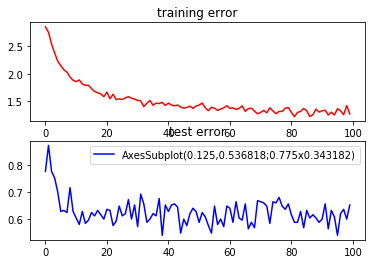

In [166]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
f, (ax1, ax2) = plt.subplots(2)
ax1.plot(train_losses, color='r')
ax2.plot(test_losses, color='b')
ax1.set_title('training error')
ax2.set_title('test error')
plt.legend([ax1, ax2])
plt.show()